# Work for PSTAT 135 Group Project - Alexis Navarra

In [80]:
# libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## begin project EDA using Wyoming data

In [40]:
## read in data from personal directory
#data = "gs://pstat-135-an/notebooks/jupyter/data/"
#!gsutil ls {data + "group-19-project-data"}

## read in parquet files
bucket_dir = 'gs://pstat135-voter-file/VM2Uniform/'
WY_df = spark.read.parquet(bucket_dir + 'VM2Uniform--WY--2021-01-13')

In [41]:
## see all columns in dataset
# WY_df.printSchema()

### Relevant Fields:
LALVOTERID: string
Board_of_Education_District: string
County_Board_of_Education_District: string
CommercialData_Education: string 
CommercialData_AreaMedianEducationYears: string 
CommercialDataLL_Interest_in_Education_Online_In_Household: string 
ElectionReturns_G08CountyTurnoutAllRegisteredVoters: string

In [68]:
keep = ['LALVOTERID', 'County', 'Board_of_Education_District', 'County_Board_of_Education_District', 
        'CommercialData_Education', 'CommercialData_AreaMedianEducationYears', 
        'CommercialDataLL_Interest_in_Education_Online_In_Household', 'ElectionReturns_G08CountyTurnoutAllRegisteredVoters']
#WY_df.select(keep).show(20)

In [65]:
## clean education level column
ed_lvl_combine = when(WY_df.CommercialData_Education.like('Grad Degree%'), 'Grad Degree')\
                .when(WY_df.CommercialData_Education.like('Bach Degree%'), 'Bach Degree')\
                .when(WY_df.CommercialData_Education.like('Vocational Technical Degree%'), 'Vocational Technical Degree')\
                .when(WY_df.CommercialData_Education.like('Some College%'), 'Some College')\
                .when(WY_df.CommercialData_Education.like('HS Diploma%'), 'HS Diploma')\
                .when(WY_df.CommercialData_Education.like('Less than HS Diploma%'), 'Less Than HS Diploma')\
                .otherwise('Null')
WY_df = WY_df.withColumn("Education_Lvl", ed_lvl_combine)

In [69]:
## find counts and proportions of each level of education for the state of Wyoming
from pyspark.sql.functions import col, countDistinct, round, when

total_state_voters = WY_df.select('LALVOTERID').count()

ed_lvl_st_cnt = WY_df.groupBy(['Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_st_cnt = ed_lvl_st_cnt.withColumnRenamed('count(LALVOTERID)', 'num_voters')
ed_lvl_state = ed_lvl_st_cnt.withColumn('prcnt_of_total', round(((col('num_voters')/total_state_voters)*100), 2))
ed_lvl_state.show()

+--------------------+----------+--------------+
|       Education_Lvl|num_voters|prcnt_of_total|
+--------------------+----------+--------------+
|Less Than HS Diploma|      5875|          2.02|
|          HS Diploma|     53446|          18.4|
|         Bach Degree|     47700|         16.43|
|         Grad Degree|     24520|          8.44|
|Vocational Techni...|       374|          0.13|
|        Some College|     53566|         18.45|
|                Null|    104927|         36.13|
+--------------------+----------+--------------+



<AxesSubplot:ylabel='Education_Lvl'>

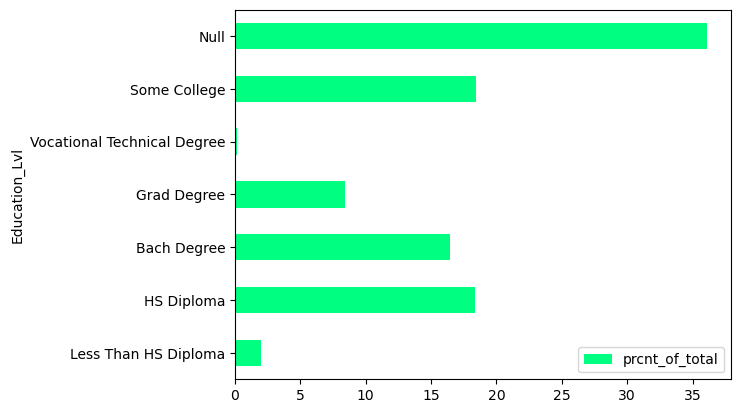

In [82]:
## visualize above

ed_lvl_state_pd = ed_lvl_state.toPandas()
ed_lvl_state_pd.plot(kind='barh', x='Education_Lvl', y='prcnt_of_total', colormap='winter_r')

In [72]:
## find counts and proportions of each level of education for each county in the state of Wyoming
from pyspark.sql.functions import col, countDistinct, round

county_voters = WY_df.groupBy('County').agg(countDistinct('LALVOTERID'))
county_voters = county_voters.withColumn("voter_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 

ed_lvl_county_cnt = WY_df.groupBy(['County','Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_county_cnt = ed_lvl_county_cnt.withColumn("ed_level_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 
ed_lvl_by_county = ed_lvl_county_cnt.join(county_voters, 'County')
ed_lvl_by_county = ed_lvl_by_county.withColumn("prcnt_of_total", round(((col("ed_level_total")/col("voter_total"))*100), 2))
ed_lvl_by_county.show()

+-------+--------------------+--------------+-----------+--------------+
| County|       Education_Lvl|ed_level_total|voter_total|prcnt_of_total|
+-------+--------------------+--------------+-----------+--------------+
|JOHNSON|Less Than HS Diploma|            95|       5120|          1.86|
|JOHNSON|                Null|          1595|       5120|         31.15|
|JOHNSON|          HS Diploma|          1030|       5120|         20.12|
|JOHNSON|Vocational Techni...|             8|       5120|          0.16|
|JOHNSON|        Some College|           989|       5120|         19.32|
|JOHNSON|         Bach Degree|           950|       5120|         18.55|
|JOHNSON|         Grad Degree|           453|       5120|          8.85|
| WESTON|                Null|          1142|       3626|         31.49|
| WESTON|        Some College|           682|       3626|         18.81|
| WESTON|          HS Diploma|           929|       3626|         25.62|
| WESTON|Less Than HS Diploma|            92|      

In [84]:
## visualize above
## distribution of grad degrees per county
grad_dgs_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Grad Degree")
grad_dgs_by_county_pd = grad_dgs_by_county.toPandas()
#grad_dgs_by_county_pd.plot(kind='barh', x='County', y='prcnt_of_total', colormap='winter_r')

## distribution of bach degrees per county
bach_dgs_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Bach Degree")
bach_dgs_by_county_pd = bach_dgs_by_county.toPandas()
#bach_dgs_by_county_pd.plot(kind='barh', x='County', y='prcnt_of_total', colormap='winter_r')

## distribution of vocational technical degrees per county
voc_dgs_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Vocational Technical Degree")
voc_dgs_by_county_pd = voc_dgs_by_county.toPandas()
#voc_dgs_by_county_pd.plot(kind='barh', x='County', y='prcnt_of_total', colormap='winter_r')

## distribution of some college per county
some_col_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Some College")
some_col_by_county_pd = some_col_by_county.toPandas()
#some_col_by_county_pd.plot(kind='barh', x='County', y='prcnt_of_total', colormap='winter_r')

## distribution of hs diploma per county
hs_dip_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "HS Diploma")
hs_dip_by_county_pd = hs_dip_by_county.toPandas()
#hs_dip_by_county_pd.plot(kind='barh', x='County', y='prcnt_of_total', colormap='winter_r')

## distribution of less than hs diploma per county
less_thn_hs_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Less Than HS Diploma")
less_thn_hs_by_county_pd = less_thn_hs_by_county.toPandas()
#less_than_hs_by_county_pd.plot(kind='barh', x='County', y='prcnt_of_total', colormap='winter_r')

## distribution of null education level per county
null_ed_lvl_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Null")
null_ed_lvl_by_county_pd = null_ed_lvl_by_county.toPandas()
#null_ed_lvl_by_county_pd.plot(kind='barh', x='County', y='prcnt_of_total', colormap='winter_r')

## merge plots (somehow)